In [751]:
import os
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999

import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [752]:
from Axe_Object import Axe

In [753]:
filenames = [name for name in os.listdir('axe_specs/') if not name.startswith('.')] # Ignores hidden files on mac

In [770]:
axes = []
for filename in filenames:
    try:
        this_axe = Axe(filename)
        if "LOT OF" not in this_axe.title.upper() and this_axe.price_usd > 100 and this_axe.price_usd < 1750:
            if this_axe.string_config and this_axe.string_config < 5:
                continue
            if this_axe.market != 'EBAY-US':
                continue
            if this_axe.year and this_axe.year > 2019:
                continue
            axes.append(this_axe)
    except ValueError:
        pass

In [771]:
price = pd.Series([axe.price_usd for axe in axes], name = 'price')

In [772]:
auction_duration = pd.Series([axe.duration for axe in axes], name = 'auction_duration')
shipping_charged = pd.Series([axe.price_shipping for axe in axes], name = 'shipping_charged')
seller_country   = pd.Series([axe.country_seller for axe in axes], name = 'seller_country')
autopay          = pd.Series([axe.autopay for axe in axes], name = 'autopay')
returns          = pd.Series([axe.returns for axe in axes], name = 'returns')
listing_type     = pd.Series([axe.listing_type for axe in axes], name = 'listing_type')
ship_type        = pd.Series([axe.ship_type for axe in axes], name = 'ship_type')
ship_expedite    = pd.Series([axe.ship_expedite for axe in axes], name = 'ship_expedite')
start_hour       = pd.cut(pd.Series([axe.start_time.hour for axe in axes], name = 'start_hour'), 6)
end_hour         = pd.cut(pd.Series([axe.end_time.hour for axe in axes], name = 'end_hour'), 6)
start_weekday    = pd.Series([axe.start_weekday for axe in axes], name = 'start_weekday').astype('category')
end_weekday      = pd.Series([axe.end_weekday for axe in axes], name = 'end_weekday').astype('category')
returns_time     = pd.Series([axe.returns_time for axe in axes], name = "returns_time").astype('category')
num_pics         = pd.Series([axe.pic_quantity for axe in axes], name = "num_pics")
brand            = pd.Series([axe.brand for axe in axes], name = "brand")
body_type        = pd.Series([axe.body_type for axe in axes], name = "body_type")
color            = pd.Series([axe.color for axe in axes], name = "color")
right_left_handed = pd.Series([axe.right_left_handed for axe in axes], name = "right_left_handed")
best_offer_enabled = pd.Series([axe.best_offer_enabled for axe in axes], name = "best_offer_enabled")
country_manufacture = pd.Series([axe.country_manufacture for axe in axes], name = "country_manufacture")

ship_handling_time = pd.Series([axe.ship_handling_time for axe in axes], name = 'ship_handling_time').astype('category')

string_config = pd.cut(pd.Series([axe.string_config for axe in axes], name = "string_config"),
                       [0,5,6,11,20])

seller_feedback_score = pd.cut(pd.Series([axe.seller_feedback_score for axe in axes], name = "seller_feedback_score"), [-411,0,50,100,200,500,750,1250,2500,10000,100000,400000])

seller_positive_percent = pd.cut(pd.Series([axe.seller_positive_percent for axe in axes], name = "seller_positive_percent"), [-10000,99.5,111])

model_year = pd.cut(pd.Series([axe.year for axe in axes], name = "model_year"), [1700,1975,1990,1995,2000,2005,2007,2010,2011,2012,2013,2015])

# model = pd.Series([axe.model for axe in axes], name = "model")

# has_subtitle = []
# for axe in axes:
#     if axe.subtitle != None:
#         has_subtitle.append(True)
#     else: has_subtitle.append(False)
# has_subtitle = pd.Series(has_subtitle, name="has_subtitle")

# has_condition = []
# for axe in axes:
#     if axe.subtitle != None:
#         has_condition.append(True)
#     else: has_condition.append(False)
# has_condition = pd.Series(has_condition, name="has_condition")

In [773]:
# LDA_topic_weights = pd.read_csv('topic_weights.csv', index_col=0)
# LDA_topic_weights = LDA_topic_weights > 0 # Binarizing LDA topics

In [774]:
X_no_dummies = pd.concat([price, brand, color, country_manufacture, right_left_handed, best_offer_enabled, shipping_charged, 
               returns, returns_time, autopay,seller_country, ship_handling_time, listing_type, ship_expedite,
               ship_type, num_pics, auction_duration, start_hour, end_hour, start_weekday, end_weekday, 
               seller_feedback_score, seller_positive_percent, model_year, body_type, string_config],
#              LDA_topic_weights],
              axis = 1)

X = pd.get_dummies(X_no_dummies, drop_first=True)

In [775]:
X = X.dropna(subset=['price'])

In [776]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,1:], X.iloc[:,0])

### Ridge Regression

In [777]:
lin_reg = RidgeCV(alphas=[0.1, 1.0, 5.0, 10.0], cv=3).fit(X_train, y_train)

In [778]:
y_preds = lin_reg.predict(X_test)

In [779]:
price_mean = np.mean([axe.price_usd for axe in axes])
price_mean_vector = [price_mean for i in range(len(y_test))]
baseline_error = np.sqrt(mean_squared_error(y_test, price_mean_vector))
baseline_error

366.4190407249323

In [780]:
ridge_error = np.sqrt(mean_squared_error(y_test, y_preds))
ridge_error

286.6242247121548

In [781]:
print(f'So far just a {round((((baseline_error - ridge_error) / baseline_error) * 100),2)}% improvement over guessing the mean.')

So far just a 21.78% improvement over guessing the mean.


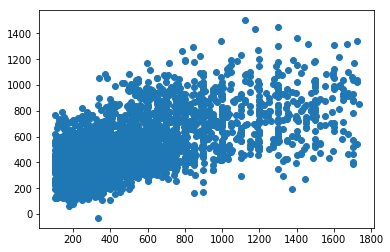

In [782]:
plt.scatter(y_test, y_preds)
plt.show()